# Optimizations (Draft)

## OR-tools

https://developers.google.com/optimization/introduction/python

In [ ]:
!pip install ortools

     |████████████████████████████████| 13.7MB 328kB/s 
     |████████████████████████████████| 1.3MB 48.0MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


Maximize $3x+y$

Subjected to:

$0 \le x \le 1$

$0 \le y \le 2$

$x+y \le 2$

In [ ]:
# Step 1: Import the required libraries.
from __future__ import print_function
from ortools.linear_solver import pywraplp

# Step 2: Declare the solver.
# Create the linear solver with the GLOP backend.
solver = pywraplp.Solver.CreateSolver('GLOP')

# Step 3: Create the variables.
x = solver.NumVar(0, 1, 'x')
y = solver.NumVar(0, 2, 'y')

print('Number f variables = ', solver.NumVariables())

# Define the constraints.
# The first two constraints are already set. The following code defines the remaining constraint
# Create a linear constraint, 0 <= x + y <= 2.
ct = solver.Constraint(0, 2, 'ct')
ct.SetCoefficient(x, 1)
ct.SetCoefficient(y, 1)

print('Number of constraints =', solver.NumConstraints())

# Step 4: Define the objective function.
objective = solver.Objective()
objective.SetCoefficient(x, 3)
objective.SetCoefficient(y, 1)
objective.SetMaximization()

# Step 5: Invoke the solver and display the results.
solver.Solve()
print('Objective value =', objective.Value())
print('x =', x.solution_value())
print('y =', y.solution_value())




## My Simplex Method implementation

In [ ]:
import numpy as np

class SimplexSolver():
    """A solver of standard form with simplex method."""
    def __init__(self):
        self.m = int(input("Number of constraints: "))
        self.n = self.m + int(input("Number of variables: "))
        self.B = [i for i in range(self.n - self.m, self.n)]
        self.N = [i for i in range(self.n - self.m)]
        self.c = np.array([[float(i)] for i in input("Coefficient of objective: ").split()] + [[0]]*self.m)
        print("Coefficient of constraint:")
        container = []
        for _ in range(self.m):
            container.append([float(i) for i in input().split()])
        
        self.A = np.hstack((np.array([row[:-1] for row in container]), np.identity(self.m)))
        self.b = np.array([[row[-1]] for row in container])
        
        self.p, self.Q, self.z, self.r = [], [], [], []
        self._update_tablaeu()
        self._solve()

    def objective_value(self):
        return self.z[0, 0]
    
    def optimal_solution(self):
        if self.z != float('inf'):
            result = [0]*(self.n - self.m)
            for j in range(self.m):
                if self.B[j] in range(self.n - self.m):
                    result[self.B[j]] = self.p[j, 0]
            return result
        else: return None

    def _update_tablaeu(self):
        self.p = np.linalg.inv(self._part(self.A, self.B)) @ self.b
        self.Q = - np.linalg.inv(self._part(self.A, self.B)) @ self._part(self.A, self.N)
        self.z = (self._part(self.c, self.B, False)).T @ np.linalg.inv(self._part(self.A, self.B)) @ self.b
        self.r = self._part(self.c, self.N, False) - ((self._part(self.c, self.B, False)).T @ np.linalg.inv(self._part(self.A, self.B)) @ self._part(self.A, self.N)).T
    
    def _part(self, A, B, column=True):
            return np.hstack([A[:, i:i+1] for i in B]) if column else np.vstack([A[i:i+1, :] for i in B])

    def _entering_position(self):
        """Return the INDEX in N of the basic-entering variable, which has positive coefficient."""
        for j in range(self.n - self.m):
            if self.r[j, 0] > 0:
                return j
        return None

    def _leaving_position(self, beta):
        """Return the INDEX in B of the basic-leaving variable, or None if there is no row with a negative coefficient of entering variable (unbounded)"""
        lower_bound = sorted([(- self.p[i, 0]/self.Q[i, beta], i) for i in range(self.m) if self.Q[i, beta] < 0])
        return lower_bound[0][1]

    def _solve(self): # must handle the no BFS case
        beta = self._entering_position() 
        while beta != None:
            alpha = self._leaving_position(beta)
            self._status()                      # REMOVE this line in execution
            if alpha == None: 
                self.z = float('nf')
                return
            else:
                self.B[alpha], self.N[beta] = self.N[beta], self.B[alpha]
                self._update_tablaeu()
                beta = self._entering_position()


    def _status(self):
        print(self.B, self.N)
        print(self.p)
        print(self.Q)
        print(self.z)
        print(self.r)

solver = SimplexSolver()
print(solver.objective_value())
print(solver.optimal_solution())


## Mixed integer programming

Maximize $x + 10y$ 

subject to:

$x + 7y \le 17.5$

$x \le 3.5$

$x \ge 0$

$y \ge 0$

$x, y$ are integers

In [ ]:
# Import the linear solver wrapper
from ortools.linear_solver import pywraplp

# Declare the MIP solver
solver = pywraplp.Solver.CreateSolver('SCIP')

INF = solver.infinity()

x = solver.IntVar(0.0, INF, 'x')
y = solver.IntVar(0.0, INF, 'y')

# Define the constraints
solver.Add(x + 7*y <= 17.5)
solver.Add(x <= 3.5)

# Define the objective
solver.Maximize(x + 10*y)

# Call the MIP solver
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    print('x =', x.solution_value())
    print('y =', y.solution_value())
else:
    print('The problem does not have an optimal solution.')

Objective value = 23.0
x = 3.0
y = 2.0


BCA problem

In [ ]:
# BCA problem


from ortools.linear_solver import pywraplp
import numpy as np

solver = pywraplp.Solver.CreateSolver('SCIP')
INF = solver.infinity()

T, N = 3, 13
credits = np.array([3,3,4,3,4,3,3,3,4,3,3,4,4])
preference = np.array([[1,0,1,1,1,0,0,0,1,0,1,0,0],[1,1,0,1,0,1,1,1,1,0,0,0,0],[0,1,1,1,0,0,0,1,0,1,0,1,1]])
conflict = np.array([[0,2],[0,4],[0,8],[1,4],[1,10],[3,7],[3,9],[5,11],[5,12],[6,8],[6,12]])

X = np.array([[None]*N for _ in range(T)])
Y = solver.IntVar(-INF, INF, 'Y')
for i in range(T):
    for j in range(N):
        X[i, j] = solver.IntVar(0.0, float(preference[i, j]), 'X[{}, {}]'.format(i, j))

for i in range(T):
    solver.Add(Y >= sum(X[i, j]*credits[j] for j in range(N)))

for j in range(N):
    solver.Add(sum(X[:, j]) <= 1)

for j in range(N):
    solver.Add(sum(X[:, j]) >= 1)

for i in range(T):
    for j1, j2 in conflict:
        solver.Add(X[i, j1] + X[i, j2] <= 1)

solver.Minimize(Y)

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    print([[j for j in range(N) if X[i, j].solution_value() == 1] for i in range(T)])
else:
    print('The problem does not have an optimal solution.')


Objective value = 14.999999999999998
[[3, 4, 8, 10], [0, 1, 5, 6, 7], [2, 9, 11, 12]]


In [ ]:
# MINI project
import numpy as np
from ortools.linear_solver import pywraplp


n, m, k = 10, 7, 3
prefer = np.array([[1, 2, 4, 6, 7], [1, 3, 7, 2, 4, 5], [2, 6, 7, 1], [4, 5, 2, 1, 7], [3, 6, 7, 1, 2], [4, 1, 5, 3, 6], [1, 2, 6], [2, 4, 7, 5], [5, 3, 1, 4], [5, 4, 2, 1, 3]])

solver = pywraplp.Solver.CreateSolver('SCIP')
INF = solver



In [ ]:
def sudoku():
    A = np.array([[None] * 9 for _ in range(9)])

    def markR(v, r):
        return v in A[r, :]

    def markC(v, c):
        return v in A[:, c]

    def markS(v, i, j):
        return v in A[i // 3 * 3: i // 3 * 3 + 3, j // 3 * 3: j // 3 * 3 + 3]

    def Try(r, c):
        for v in range(1, 10):
            if not (markR(v, r) or markC(v, c) or markS(v, r, c)):
                A[r, c] = v
                if r == c == 8:
                    exit(A)
                elif c == 8:
                    Try(r + 1, 0)
                else:
                    Try(r, c + 1)
                A[r, c] = None

    Try(0, 0)



In [ ]:
# TSP problem

import numpy as np
import time

#c = np.array([[0,1,1,6],[1,0,7,1],[1,7,0,1],[6,1,1,0]])
c = np.array([[0,1,1,6,7],[1,0,7,1,2],[1,7,0,1,4],[6,1,1,0,9],[3,5,2,3,0]])
N,N = c.shape
cmin = 1e9

def input(filename):
	global N,c
	with open(filename) as f:
		for line in f:
			N = int(line)# read the number of points
			print('N = ',N)
			break
			
		c = np.array([[int(num) for num in line.split()] for line in f])# read the whole distance matrix
		print('c = ',c)

def Computecmin():
	global cmin
	for i in range(N):
		for j in range(N):
			if i != j and cmin > c[i,j]:
				cmin = c[i,j]
	

def Solution():
	global f
	global min_f, start_time	
	if f + c[X[N-1],X[0]] < min_f:
		min_f = f + c[X[N-1],X[0]]
		x_best[:] = X[:]
		print('update best ',min_f,' time = ', time.time() - start_time,' (s)')
	
def SortedCandidates(cur):
	cand = []
	for v in range(N):
		if mark[v] == False:
			cand.append(v)
	cand.sort(key = lambda x: c[cur,x])
	return cand
		
def Try(k):
	global f	
	cand = SortedCandidates(X[k-1])
	for v in cand:
		X[k] = v
		mark[v] = True
		f = f + c[X[k-1],X[k]]
		if k == N-1:
			Solution()
		else:
			g = f + cmin*(N-k)
			if g < min_f:
				Try(k+1)
				
		f = f - c[X[k-1],X[k]]
		mark[v] = False
input('dataTSP/TSP-15.inp')	
Computecmin()		
X = np.zeros(N,dtype='int')
f = 0 #accumulated total travel distance of the route
min_f = 1000000 #best distance
x_best = np.zeros(N,dtype='int')

mark = np.zeros(N,dtype='bool')

start_time = time.time()
X[0] = 0
mark[0] = True
Try(1)			
print(x_best,' distance = ',min_f)
print('time = ',time.time() - start_time,'(s)')

In [ ]:
# My TSP implementation
import numpy as np

# edge_min: shortest distance between 2 connected cities
# cur_distance: distance moved in the considered case
# min_distance: shortest path recorded


def compute_min_edge():
    min_edge = float('inf')
    for i in range(N):
        for j in range(N):
            if graph[i, j]!= 0 and graph[i, j] < min_edge:      # graph[i, j] == 0 means there is no connection between 2 cities
                min_edge = graph[i, j]
    return min_edge

def remaining_cities(k):
    container = [city for city in range(N) if not traveled[city]]
    container.sort(key = lambda city: graph[cur_path[k - 1], city])
    return container

def update_best():
    global min_distance
    if cur_distance + graph[cur_path[-1], cur_path[0]] < min_distance:      # do NOT acumulate cur_distance with graph[cur_path[-1], cur_path[0]]
        min_distance = cur_distance + graph[cur_path[-1],cur_path[0]]
        best_path[:] = cur_path[:]

def Try(k):
    global cur_distance
    for city in remaining_cities(k):
        if not traveled[city]:
            cur_path[k] = city
            traveled[city] = True
            cur_distance += graph[cur_path[k - 1], city]
            if k == N - 1:
                update_best()
            else:
                if cur_distance + min_edge*(N - k) < min_distance:
                    Try(k + 1)
            cur_distance -= graph[cur_path[k - 1], city]
            traveled[city] = False

def my_input():
    return 10, np.array([[0, 68, 35, 1, 70, 25, 79, 59, 63, 65],
                         [6, 0, 82, 28, 62, 92, 96, 43, 28, 37],
                         [92, 5, 0, 54, 93, 83, 22, 17, 19, 96],
                         [48, 27, 72, 0, 70, 13, 68, 100, 36, 95],
                         [4, 12, 23, 34, 0, 65, 42, 12, 54, 69],
                         [48, 45, 63, 58, 38, 0, 24, 42, 30, 79],
                         [17, 36, 91, 43, 89, 7, 0, 43, 65, 49],
                         [47, 6, 91, 30, 71, 51, 7, 0, 94, 49],
                         [30, 24, 85, 55, 57, 41, 67, 77, 0, 9],
                         [45, 40, 27, 24, 38, 39, 19, 83, 30, 0]])



N, graph = my_input()
min_distance = float('inf')             
min_edge = compute_min_edge()           # compute the shortest among distances between 2 cities
best_path = [None] * N
cur_path = [0] * N
cur_distance = 0
traveled = [False] * N
traveled[0] = True
Try(1)
print(best_path, min_distance)




[0, 3, 8, 9, 2, 7, 6, 5, 4, 1] 160


## Constraint Optimization

Three variables,$x$, $y$, and $z$, each of which can take on the values: $0$, $1$, or $2$.

One constraint: $x ≠ y$

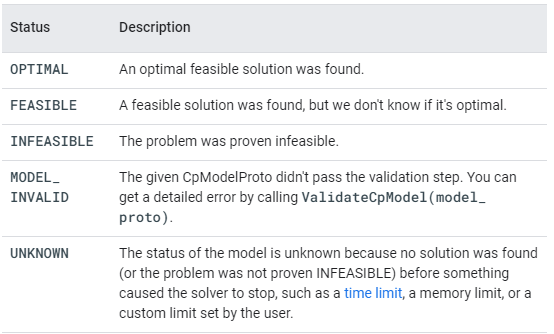

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ortools.sat.python import cp_model


class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0

    def on_solution_callback(self):
        self.__solution_count += 1
        for v in self.__variables:
            print('%s=%i' % (v, self.Value(v)), end=' ')
        print()

    def solution_count(self):
        return self.__solution_count


def SearchForAllSolutionsSampleSat():
    """Showcases calling the solver to search for all solutions."""
    # Creates the model.
    model = cp_model.CpModel()

    # Creates the variables.
    num_vals = 3
    x = model.NewIntVar(0, num_vals - 1, 'x')
    y = model.NewIntVar(0, num_vals - 1, 'y')
    z = model.NewIntVar(0, num_vals - 1, 'z')

    # Create the constraints.
    model.Add(x != y)

    # Create a solver and solve.
    solver = cp_model.CpSolver()
    solution_printer = VarArraySolutionPrinter([x, y, z])
    status = solver.SearchForAllSolutions(model, solution_printer)

    print('Status = %s' % solver.StatusName(status))
    print('Number of solutions found: %i' % solution_printer.solution_count())


SearchForAllSolutionsSampleSat()

1 0 0


# Numpy (Draft)

```
>>> np.arange(6)
[0 1 2 3 4 5]
```

```
>>> np.arrange(6).reshape(2, 3)
[[0 1 2]
 [3 4 5]]
```

```




In [ ]:
import numpy as np

a = np.arange(6).reshape(2, 3)

print(a.ndim)

# Data Structure and Algorithms (Draft)

In [ ]:
  class Empty(Exception):
      pass

"""S.push(e)
S.pop()
S.top()
S.is_empty()
len(S)
"""

class ArrayStack():

    def __init__(self):
        self._data = []

    def __len__(self):
        return len(self._data)

    def is_empty(self):
        return len(self) == 0

    def push(self, e):
        self._data.append(e)

    def pop(self):
        if self.is_empty():
            raise Empty
        return self._data.pop()

    def top(self):
        if self.is_empty():
            raise Empty
        return self._data[-1]

"""
Q.enqueue(e)
Q.dequeue()
Q.first()
Q.is_empty()
len(Q)
"""
     
class ArrayQueue():

    DEFAULT_CAPACITY = 40

    def __init__(self):
        self._data = [None] * ArrayQueue.DEFAULT_CAPACITY
        self._n = 0
        self._f = 0

    def __len__(self):
        return self._n

    def is_empty(self):
        return len(self) == 0

    def first(self):
        if self.is_empty():
            raise Empty
        return self._data[self._f]

    def enqueue(self, e):
        if self._n == len(self._data):
            self._resize(len(self._data)*2)
        self._data[(self._f + self._n) % len(self._data)] = e
        self._n += 1

    def dequeue(self):
        if self.is_empty():
            raise Empty
        e = self._data[self._f]
        self._data[self._f] = None
        self._f = (self._f + 1) % len(self._data)
        self._n -= 1
        if 0 < self._n < len(self._data) // 4:
            self._resize(len(self._data) // 2)
        return e
        
    def _resize(self, cap):
        old = self._data
        self._data = [None]*cap
        for k in range(self._n):
            self._data[k] = old[(self._f + k) % len(old)]
        self._f = 0

"""
D.add_first(e)
D.add_last(e)
D.delete_first()
D.delete_last()
D.first()
D.last()
D.is_empty()
len(D)
"""

class ArrayDeque:
    
    DEFAULT_CAPACITY = 40

    def __init__(self):
        self._data = [None] * Deque.DEFAULT_CAPACITY
        self._n = 0
        self._f = 0

    def __len__(self):
        return self._n

    def is_empty(self):
        return len(self) == 0

    def first(self):
        if self.is_empty():
            raise Empty
        return self._data[self._f]

    def last(self):
        if self.is_empty():
            raise Empty
        return self_data[(self._f + self._n - 1) % len(self._data)]

    def add_first(self, e):
        if self._n == len(self._data):
            self._resize(len(self._data)*2)
        self._f = (self._f - 1) % len(self._data)
        self._data[self._f] = e
        self._n += 1

    def add_last(self, e):
        if self._n == len(self._data):
            self._resize(len(self._data)*2)
        self._data[(self._f + self._n) % len(self._data)] = e
        self._n += 1

    def delete_first(self):
        if self.is_empty():
            raise Empty
        e = self._data[self._f]
        self._data[self._f] = None
        self._f = (self._f + 1) % len(self._data)
        self._n -= 1
        if 0 < self._n < len(self._data) // 4:
            self._resize(len(self._data) // 2)
        return e

    def delete_last(self):
        if self.is_empty():
            raise Empty
        e = self._data[(self._f + self._n - 1) % len(self._data)]
        self._data[(self._f + self._n - 1) % len(self._data)] = None
        self._n -= 1
        if 0 < self._n < len(self._data)// 4:
            self._resize(len(self._data)//2)
        return e

    def _resize(self, cap):
        old = self._data
        self._data = [None]*cap
        for k in range(self._n):
            self._data[k] = old[(self._f + k) % len(old)]
        self._f = 0
        





## Tree

In [ ]:
class Empty(Exception):
    pass

class Tree:
    
    class Position:

        def element(self):
            raise NotImplementedError

        def __eq__(self, other):
            """Return True if other Position represents the same location"""
            raise NotImplementedError

        def __ne__(self, other):
            return not (self == other)


    def root(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def is_empty(self):
        return len(self) == 0

    def is_root(self, p):
        return self.root() == p

    def parent(self, p):
        raise NotImplementedError

    def children(self, p):
        raise NotImplementedError

    def num_children(self, p):
        raise NotImplementedError

    def is_leaf(self, p):
        return self.num_children(p) == 0

    def depth(self, p):
        if self.is_root(p):
            return 0
        else:
            return 1 + self.depth(self.parent(p))

    def _height(self, p):
        if self.is_leaf(p):
            return 0
        else:
            return 1 + max(self._height(c) for c in self.children(p))

    def height(self, p=None):
        if p is None:
            p = self.root()
        return self._height(p)

    def preorder(self, p):
        yield p
        for c in self.children(p):
            self.preorder(c)

    def postorder(self, p):
        for c in self.children(p):
            self.postorder(p)
        yield p

    def breathfirst(self, p):
        fringe = LinkedQueue()
        fringe.enqueue(p)
        while not Q.is_empty():
            p = Q.dequeue()
            yield p
            for c in self.children(p):
                Q.enqueue(c)

    def eulertour(self, p):
        yield p
        for c in self.children(p):
            self.eulertour(c)
        yield p



class BinaryTree(Tree):

    def left(self, p):
        """Return None if p does not have a left child."""
        raise NotImplementedError

    def right(self, p):
        """Return None if p does not have a right chilf."""
        raise NotImplementedError

    def children(self, p):
        if self.left(p) is not None:
            yield self.left(p)
        if self.right(p) is not None:
            yield self.right(p)

    def sibling(self, p):
        parent = self.parent(p)
        if parent is None:
            return None
        else:
            if p == self.left(parent):
                return self.right(parent)
            else:
                return self.left(parent)


class LinkedBinaryTree(BinaryTree):

    class _Node:
        __slot__ = '_element', '_parent', '_left', '_right'

        def __init__(self, element, parent=None, left=None, right=None):
            self._element = element
            self._parent  = parent
            self._left    = left
            self._right   = right

    class Position(BinaryTree.Position):
        
        def __init__(self, container, node):
            self._container = container
            self._node = node

        def element(self):
            return self.node._element

        def __eq__(self, other):
            return type(other) is type(self) and self._node is other._node

    # ----------------------------------------------------------------------------------

    def _make_position(self, node):
        """Return a Position instance for the given node, or None if no node."""
        return self.Position(self, node) if node is not None else None

    def _get_node(self, p):
        if not isinstance(p, self.Position):
            raise TypeError('p must be proper Position type')
        if p._container is not self:
            raise ValueError('p does not belong to this container')
        if p._node._parent is p._node:               # convention for deprecated node
            raise ValueError('p is no longer valid')
        return p._node

    # ----------------------------------------------------------------------------------

    def __init__(self):
        self._root = None
        self._size = 0

    def root(self):
        return self._make_position(self._root)

    def __len__(self):
        return self._size

    def parent(self, p):
        return self._make_position(self._get_node(p)._parent)

    def num_children(self, p):
        node = self._get_node(p)
        count = 0
        if node._left is not None:
            count += 1
        if node._right is not None:
            count += 1
        return count

    def left(self, p):
        """Return None if p does not have a left child."""
        return self._make_position(self._get_node(p)._left)

    def right(self, p):
        """Return None if p does not have a right chilf."""
        return self._make_position(self._get_node(p)._right)

    # -------------------------------------------------------------------------

    def add_root(self, e):
        if self._root is not None:
            raise ValueError('Root exists')
        self._root = self._Node(e)
        self._size = 1
        return self._make_position(self._root)

    def add_left(self, p, e):
        node = self._get_node(p)
        if node._left is not None:
            raise ValueError('Left child exists')
        node._left = self._Node(e, node)
        self._size += 1
        return self._make_position(node._left)

    def add_right(self, p, e):
        node = self._get_node(p)
        if node._right is not None:
            raise ValueError('Right child exists')
        node._right = self._Node(e, node)
        self._size += 1
        return self._make_position(node._right)

    def replace(self, p, e):
        node = self._get_node(p)
        old = node._element
        node._element = e
        return old

    def _delete(self, p):
        node = self._get_node_(p)
        if self.num_children(p) == 2:
            raise ValueError('p has 2 children')
        child = node._left if node._left else node._right
        if child is not None:
            child._parent = node._parent
        if node is self._root:
            self._root = child
        else:
            if node is node._parent._left:
                node._parent.left = child
            else:
                node._parent._right = child
        self._size -= 1
        node._parent = node                     # convention for deprecated node
        return node._element                    

    def _attach(self, p, T1, T2):
        node = self._get_node(p)
        if not self.is_leaf(p):
            raise ValueError('p must be leaf')
        if not type(self) is type(t1) is type(t2):
            raise TypeError('Tree types must match')
        self._size += len(T1) + len(T2)
        if not is_empty(T1):
            T1._root._parent = node
            node._left = T1._root
            t1._root = None
            t1._size = 0
        if not is_empty(T2):
            T2._root._parent = node
            node._right = T2._root
            T2._root = None
            T2._size = 0

    def inorder(self, p):
        if self.left(p) is not None:
            self.inorder(self.left(p))
        yield p
        if self.right(p) is not None:
            self.inorder(self.right(p))


    


## Dynamic programming

In [ ]:
def fib_1(n):
    tab = [None] * (n + 1)
    tab[0], tab[1] = 0, 1
    for i in range(2, n + 1):
        tab[i] = tab[i - 1] + tab[i - 2]
    return tab[n]


def fib_2(n):
    tab = [0, 1, None]
    x, y, z = 0, 1, 2
    for i in range(2, n + 1):
        tab[z] = tab[y] + tab[x]
        x, y, z = y, z, x
    return tab[y]


def making_change(M, arr):
    tab = [i for i in range(M + 1)]
    for val in arr[1:]:
        for i in range(1, M + 1):
            if i >= val:
                tab[i] = min(tab[i], tab[i - val] + 1)
    return tab[-1]


def knapsack(MAX_W, weights, values):
    n = len(weights)
    MAX_LOAD = [[(0 if i < weights[0] else values[0]) for i in range(MAX_W + 1)], [None] * (MAX_W + 1)]
    cur, nex = 0, 1
    for j in range(1, n):
        for i in range(MAX_W + 1):
            if i < weights[j]:
                MAX_LOAD[nex][i] = MAX_LOAD[cur][i]
            else:
                MAX_LOAD[nex][i] = max(MAX_LOAD[cur][i], MAX_LOAD[cur][i - weights[j]] + values[j])
        cur, nex = nex, cur
    return MAX_LOAD[cur][-1]

knapsack(10, [6, 5, 4, 2, 2], [6, 3, 5, 4, 6])


16

# Discrete mathematics

In [ ]:
def backtracking_subset(a, m):
    n = len(a)
    sub_indexes = [-1] * (m + 1)

    def Try(k):
        for i in range(sub_indexes[k - 1] + 1, n - m + k):
            sub_indexes[k] = i
            if k == m:
                print([a[index] for index in sub_indexes[1:]])
            else:
                Try(k + 1)
    Try(1)

def backtracking_permutation(a):
    n = len(a)
    per = [None] * n
    
    def Try(k):
        for i in a:
            if i not in per:
                per[k] = i
                if k == n - 1:
                    print(per)
                else:
                    Try(k + 1)
                per[k] = None
    Try(0)
    

def pstv_itg_root(n, k):    
    solution = [1] * k
    
    def Try(t):
        for i in range(1, n - sum(solution[:t])):
            solution[t] = i
            if t == k - 2:
                solution[-1] = n - sum(solution[:-1])
                print(solution)
            else:
                Try(t + 1)
    Try(0)
    

def knapsack_backtracking(w_max, weights, values):
    n = len(weights)
    total_weight = total_value = max_value = 0
    best_choice = [False] * n
    picked = [False] * n

    def Try(k):
        global total_weight, total_value, max_value
        if total_weight + 
        for value in (True, False):
            picked[k] = value
            if total_weight 
            if total_weight + weights[k] <= w_max:
                picked[k] = True
                total_weight += weights[k]
                total_value += values[k]
                Try(k + 1)
                picked[k] = False
                total_weight -= weights[k]
                total_value -= values[k]
            else:
                if total_value > max_value:
                    max_value = total_value
                    best_choice[:] = picked[:]
            print(picked, total_value, total_weight)
                
    Try(0)
    return best_choice, max_value

print(knapsack_backtracking(10, [6, 5, 4, 2, 2], [6, 3, 5, 4, 6]))





[False, False, False, False, False] 6 6
[False, False, False, False, False] 6 6
([False, False, False, False, False], 0)


# Others' solutions

## [Human readable duration format](https://www.codewars.com/kata/52742f58faf5485cae000b9a/python)

```
1 minute and 2 seconds
1 hour, 1 minute and 2 seconds
```

In [ ]:
times = [("year", 365 * 24 * 60 * 60), 
         ("day", 24 * 60 * 60),
         ("hour", 60 * 60),
         ("minute", 60),
         ("second", 1)]

def format_duration(seconds):

    if not seconds:
        return "now"

    chunks = []
    for name, secs in times:
        qty = seconds // secs
        if qty:
            if qty > 1:
                name += "s"
            chunks.append(str(qty) + " " + name)

        seconds = seconds % secs

    return ', '.join(chunks[:-1]) + ' and ' + chunks[-1] if len(chunks) > 1 else chunks[0]

In [ ]:
def format_duration(seconds):
    if seconds == 0: return "now"
    units = ( (31536000, "year"  ), 
              (   86400, "day"   ),
              (    3600, "hour"  ),
              (      60, "minute"),
              (       1, "second") )
    ts, t = [], seconds
    for unit in units:
        u, t = divmod(t, unit[0])
        ts += ["{} {}{}".format(u, unit[1], "s" if u>1 else "")] if u != 0 else []
    return ", ".join([str(d)for d in ts[:-1]]) + (" and " if len(ts)>1 else "") + ts[-1]

# Exercises

In [ ]:
def key_sort(A):
    return A[1]


def natural_join(A, B):
    A.sort(key=key_sort)
    B.sort()
    c = []
    i = j = 0
    while i < len(A) and j < len(B):
        if A[i][1] == B[j][0]:
            c.append((A[i][0], A[i][1], B[j][1]))
            i += 1
            j += 1
        elif A[i][1] < B[j][0]:
            i += 1
        else:
            j += 1
        if i == len(A) or (j == len(B)):
            break
    return c

def mysum(A, r_start, r_stop, c_start, c_stop):
    if r_start == r_stop or c_start == c_stop:
        return 0
    else:
        return A[r_start][c_start] + mysum(A, r_start + 1, r_stop, c_start + 1, c_stop) + mysum(A, r_start + 1, r_stop, c_start, c_start + 1) + mysum(A, r_start, r_start + 1, c_start + 1, c_stop)

A = [[1, 2, 3],
     [4, 5, 6]]
print(mysum(A, 0, 2, 0, 3))

In [ ]:
s = ['a', 'b', 'c']
[[x for (pos,x) in zip(range(len(s)), s) if (2**pos) & b] for b in range(2**len(s))]

In [ ]:
# Xet cac day con cua S lap thanh mot cap so cong. In ra max cua cac tong cua tung day con do.
# VD: [-2, 1, -3, 4, -1, 2, 1, -5, 4] -> 8   (day so cong co tong lon nhat la: 4, 4)


def max_sum_addition(S, i):
    # find the maximum sum among sums of sequences of addtion started at S[i]

    def addition_step(start, stop):
        # return the next expected gap
        next_step = start
        while next_step < stop:
            yield next_step
            next_step += start
        yield start - 1

    # find the gap
    for j in range(i + 1, len(S)):
        S[j] -= S[i]
    
    #print(S)
    
    list_of_sums = [S[i]]

    for j in range(i + 1, len(S)):      # j is the currently considered arithmetical ratio
        gen_step = addition_step(S[j], S[-1] + 1)
        temp_sum = S[i]
        expected_step = next(gen_step)
        for k in range(j, len(S)):
            #print(S[i], expected_step, S[k])
            if S[k] == expected_step:
                temp_sum += S[i] + S[k]
                expected_step = next(gen_step)
        list_of_sums.append(temp_sum)

    #print(".", list_of_sums)
        
    for j in range(i + 1, len(S)):
        S[j] += S[i]

    return max(list_of_sums)

S = [1,2,3,4]
S.sort()
#print(S)
max_sum = max_sum_addition(S, 0)
for i in range(1, len(S)):
    candidate = max_sum_addition(S, i)
    if candidate > max_sum:
        max_sum = candidate
print(max_sum)


In [ ]:
def max_subarray(a):
    n = len(a)
    b = [float('-inf'), *a, float('inf')]
    L = [1] * (n + 2)
    T = [None] * (n + 2)
    for i in range(n, -1, -1):
        j_max = n + 1
        for j in range(i + 1, n + 2):
            #print(i, j, n + 1)
            if b[i] < b[j] and L[j] > L[j_max]:
                j_max = j
        L[i] = L[j_max] + 1
        T[i] = j_max
    return b, L, T

b, L, T = max_subarray([5, 2, 3, 4, 9, 10, 5, 6, 7, 8])
print(b)
print(L)
print(T)

In [ ]:
def matrix_mul_2(sizes):
    n = len(sizes) - 1                      # number of matrixs
    M = [[-1]*n for _ in range(n)]          # -1 denotes the value is not computed
    
    def recur_mul(i, j, sizes, M):
        if M[i][j] == -1:
            if i == j:
                M[i][j] = 0
            else:
                M[i][j] = min([recur_mul(i, k, sizes, M) + recur_mul(k + 1, j, sizes, M) + sizes[i]*sizes[k + 1]*sizes[j + 1] for k in range(i, j)])
        return M[i][j]

    return recur_mul(0, n - 1, sizes, M)

print(matrix_mul_2([10, 30, 5, 60]))

In [ ]:
def Generating(n):
    arr = ['0'] * n
    while True:
        i = n - 1
        print(''.join(arr))
        while arr[i] == '1':
            arr[i] = '0'
            i -= 1
            if i == -1:
                return
        arr[i] = '1'


def Backtracking(n):
    a = [None] * n
    
    def Try(k):
        for bit in range(2):
            a[k] = bit
            if k == n - 1: print(a)
            else: Try(k + 1)
    Try(0)

"""
boolean solve(Node n) {
    put node n on the stack;
    while the stack is not empty {
        if the node at the top of the stack is a leaf {
            if it is a goal node, return true
            else pop it off the stack
        }
        else {
            if the node at the top of the stack has untried children
                push the next untried child onto the stack
            else pop the node off the stack

    }
    return false
}

nonrecur_algo(n):
    create a stack, put node 0 in the stack
    while stack is not empty:
        if stack[-1] is leaf:
            print result
            pop that stack[-1]
        else:
            if stack[-1] has untried children:
                push the the next child to the stack
            else:
                pop that stack[-1]
"""
def Backtracking_nonrecur(n):
    value_addresses = [None] * n
    values = ['0', '1']
    k, j = 0, 0
    while k > -1:
        value_addresses[k] = j
        print(value_addresses, k, j)
        if k == n - 1:
            print([values[i] for i in value_addresses])
            k -= 1
            j = value_addresses[k] + 1
        else:
            if j < len(values) - 1:
                k += 1
                j = 0
            else:
                k -= 1
                j = value_addresses[k] + 1
            
Backtracking_nonrecur(3)

[0, None, None] 0 0
[0, 0, None] 1 0
[0, 0, 0] 2 0
['0', '0', '0']
[0, 1, 0] 1 1
[1, 1, 0] 0 1


# Summary

# Generating 

## Backtracking

In [ ]:
# backtracking: tsp, subset, permutation, positive integer root, knapsack, Bin backing problem

## Branch and bound

In [ ]:
# branch and bound: tsp, knapsack, Bin backing problem
# link Mrs Phuong: https://drive.google.com/file/d/1-ghy1y4Li9Pd-yYIZbGkFgvCv5boOB7c/view?usp=sharing


## Dynamic programming

## Making change problem


We have two choices :
1. Don’t use a coin from $d[i]$, then $t[i, j] = t[i − 1, j]$

2. Use at least one coin from $d[i]$, then $t[i, j] = t[i, j − d[i]] + 1$

So, we have $t[i, j] = min(t[i − 1, j],t[i, j − di] + 1)$

In [5]:
# dynamic: fib, knapsack, max sub arr, matrix mul, Longest common subsequence, The All-Pairs Shortest-Path Problem, 
# link Mr Michel: https://drive.google.com/file/d/1ETfNzGRAnBm1H9kRNm-QJbANflWZ0TjH/view?usp=sharing

def DP_making_change(amount, denominations):
    coins = [j for j in range(amount + 1)]              # assume that the initial value of denominations is 1
    for value in denominations[1:]:
        for j in range(amount + 1):
            if j >= value:
                coins[j] = min(coins[j], coins[j - value] + 1)
    return coins[-1]

print(DP_making_change(5, [2, 1]))


5


### Knapsack 0-1 problem



In [4]:
def DP_knapsack_01(capacity, weights, values):
    cur_table = [0 if cap < weights[0] else values[0] for cap in range(capacity + 1)]
    next_table = [None] * (capacity + 1)
    for item in range(1, len(weights)):
        for cap in range(capacity + 1):
            next_table[cap] = cur_table[cap] if cap < weights[item] else max(cur_table[cap], cur_table[cap - weights[item]] + values[item])
        cur_table, next_table = next_table, cur_table
    return cur_table[-1]

print(DP_knapsack_01(10, [6, 5, 4, 2, 2], [6, 3, 5, 4, 6]))

16


### Knapsack problem with infinite number of each item.

In [6]:
def DP_knapsack_01(capacity, weights, values):
    table = [0 if cap < weights[0] else values[0] for cap in range(capacity + 1)]
    for item in range(1, len(weights)):
        for cap in range(capacity + 1):
            if cap >= weights[item]:
                table[cap] = max(table[cap], table[cap - weights[item]] + values[item])
    return table[-1]

print(DP_knapsack_01(10, [6, 5, 4, 2, 2], [6, 3, 5, 4, 6]))

30
